# DataLoaderの実装

In [1]:
# dataset関数の実装

import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class Dataset(Dataset):
    def __init__(self, text_paths, mel_paths):
        self.text_paths = text_paths
        self.mel_paths = mel_paths
        
    def __getitem__(self, index):
        return np.load(self.text_paths[index]), np.load(self.mel_paths[index])

    def __len__(self):
        return len(self.text_paths)

In [2]:
# collate_fn関数の実装

def pad_1d(x, max_len, constant_values=0):
    """
    1次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        (0, max_len - len(x)),
        mode = "constant",
        constant_values=constant_values,
    )
    return x

def pad_2d(x, max_len, constant_values=0):
    """
    2次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        [(0, max_len - len(x)), (0, 0)],
        mode="constant",
        constant_values=constant_values,
    )
    return x

def collate_fn(batch):
    """
    PARAMS
    -------
    batch: タプルのリスト(text, mel)

    RETURNS
    -------

    MEMO
    -------
    torch.from.numpyでnumpyのArrayからtorchのTensorに変換

    """
    xs = [x[0] for x in batch]  # text list
    ys = [x[1] for x in batch]  # mel list
    in_lens = [len(x) for x in xs]  # text_len list
    out_lens = [len(y) for y in ys]  # mel_len list
    in_max_len = max(in_lens)
    out_max_len = max(out_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, in_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, out_max_len)) for y in ys])
    in_lens = torch.tensor(in_lens, dtype=torch.long)
    out_lens = torch.tensor(out_lens, dtype=torch.long)
    stop_flags = torch.zeros(y_batch.shape[0], y_batch.shape[1])
    for idx, out_len in enumerate(out_lens):
        stop_flags[idx, out_len-1 :] = 1.0
    return x_batch, in_lens, y_batch, out_lens, stop_flags

In [3]:
import glob
import torch
from torch.utils.data import DataLoader

TEXT_DIR = "F:/ROHAN4600マルチモーダルデータベース/text_data/*"
MEL_DIR = "F:/ROHAN4600マルチモーダルデータベース/mel_data/*"

textlist = sorted(glob.glob(TEXT_DIR))
mellist = sorted(glob.glob(MEL_DIR))
#print(mellist)

dataset = Dataset(textlist, mellist)
#batch_size = 32
#data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [4]:
n_samples = len(dataset)
train_size = int(len(dataset) * 0.9)
test_size = n_samples - train_size
#print(train_size)
#print(test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#print(len(train_dataset))
#print(len(test_dataset))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

4140
460
259
29


In [6]:
text, text_len, mel, mel_len, stop_flags = next(iter(train_loader))
print(tuple(text.shape))
print(tuple(mel.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(text_len.dtype)
print(mel_len.dtype)
print(tuple(stop_flags.shape))

(16, 74)
(16, 850, 80)
tensor([62, 74, 65, 28, 54, 61, 65, 66, 68, 65, 64, 60, 60, 39, 72, 71])
tensor([676, 850, 612, 358, 545, 500, 588, 537, 665, 508, 422, 436, 468, 433,
        732, 591])
torch.int32
torch.float64
torch.int64
torch.int64
(16, 850)


# 学習ループの実装

In [7]:
# 学習モデル
from Tacotron2 import Tacotron2

net = Tacotron2()
net.cuda()  # GPU対応
print(net)

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(66, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [8]:
def get_mask_from_lengths(lengths):
    """
    MEMO
    -------
    torch.maxは与えられたテンソルの最大値を返す関数
    .item()でテンソルの要素をpython組み込み型として取得
    torch.arangeは第一引数から第二引数まで第三引数間隔のテンソルが生成される
    """
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, device=lengths.device, dtype=lengths.dtype)
    mask = (ids < lengths.unsqueeze(1)).byte()
    mask = torch.le(mask, 0)
    return mask

In [9]:
mask = ~get_mask_from_lengths(mel_len)
print(mask.shape)

torch.Size([16, 850])


In [10]:
from torch import optim
import torch.nn as nn

# 平均二乗誤差
loss_fnc = nn.MSELoss()

stop_loss_fnc = nn.BCEWithLogitsLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters(), lr=0.001)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

# 損失のログ
record_loss_train = []
record_loss_test = []

# エポック数
epoch = 300

for i in range(epoch):
    net.train()
    loss_train = 0
    for j, (text, text_len, mel, mel_len, stop_flags) in enumerate(train_loader):
        
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
        text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
        # 順伝播
        outs, outs_fine, logits, att_ws = net(text, text_len, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        stop_flags = stop_flags.masked_select(mask.squeeze(-1))
        logits = logits.masked_select(mask.squeeze(-1))
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        stop_token_loss = stop_loss_fnc(logits, stop_flags)
        
        # 損失の合計
        loss = decoder_out_loss + postnet_out_loss + stop_token_loss
        
        loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
    loss_train /= j+1
    record_loss_train.append(loss_train)
    
    net.eval()
    loss_test = 0
    for j, (text, text_len, mel, mel_len, stop_flags) in enumerate(test_loader):
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
        text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
        # 順伝播
        outs, outs_fine, logits, att_ws = net(text, text_len, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        stop_flags = stop_flags.masked_select(mask.squeeze(-1))
        logits = logits.masked_select(mask.squeeze(-1))
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        stop_token_loss = stop_loss_fnc(logits, stop_flags)
        
        # 損失の合計
        loss = decoder_out_loss + postnet_out_loss + stop_token_loss
        
        loss_test += loss.item()
        
    loss_test /= j+1
    record_loss_test.append(loss_test)
    
    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)


Epoch: 0 Loss_Train: 1.5843896311222356 Loss_Test: 0.8350796062370827
Epoch: 1 Loss_Train: 0.7879369337126095 Loss_Test: 0.6454875880274279
Epoch: 2 Loss_Train: 0.6365370343090484 Loss_Test: 0.6177504370952475
Epoch: 3 Loss_Train: 0.571800026194009 Loss_Test: 0.5282599114138504
Epoch: 4 Loss_Train: 0.5277695277252713 Loss_Test: 0.4934199770976757
Epoch: 5 Loss_Train: 0.4946899144805997 Loss_Test: 0.4631746092746998
Epoch: 6 Loss_Train: 0.4732250675961778 Loss_Test: 0.4503124767336352
Epoch: 7 Loss_Train: 0.456615401165826 Loss_Test: 0.4269118298744333
Epoch: 8 Loss_Train: 0.44769810364513324 Loss_Test: 0.4259103433839206
Epoch: 9 Loss_Train: 0.4320148424062029 Loss_Test: 0.41407607341634817
Epoch: 10 Loss_Train: 0.4236807191463971 Loss_Test: 0.4108872804148444
Epoch: 11 Loss_Train: 0.43723602414591434 Loss_Test: 0.42336896370197163
Epoch: 12 Loss_Train: 0.4180277760884937 Loss_Test: 0.39554727591317274
Epoch: 13 Loss_Train: 0.41201093493741453 Loss_Test: 0.3932575871204508
Epoch: 14 Lo

Epoch: 115 Loss_Train: 0.3189455343834682 Loss_Test: 0.3225834595746008
Epoch: 116 Loss_Train: 0.3171961822449931 Loss_Test: 0.3310137976860178
Epoch: 117 Loss_Train: 0.31656104280221414 Loss_Test: 0.32167842778666267
Epoch: 118 Loss_Train: 0.3168821399276321 Loss_Test: 0.33224282388029425
Epoch: 119 Loss_Train: 0.3165235057990984 Loss_Test: 0.3181225945209635
Epoch: 120 Loss_Train: 0.31933800807100465 Loss_Test: 0.322872093011593
Epoch: 121 Loss_Train: 0.31712336412497927 Loss_Test: 0.32579475435717353
Epoch: 122 Loss_Train: 0.3189057376969275 Loss_Test: 0.3166243814188859
Epoch: 123 Loss_Train: 0.31767399798949253 Loss_Test: 0.32028282819123105
Epoch: 124 Loss_Train: 0.3152506371607652 Loss_Test: 0.33126468288487404
Epoch: 125 Loss_Train: 0.3148764886796244 Loss_Test: 0.33068932335952234
Epoch: 126 Loss_Train: 0.3179302896196778 Loss_Test: 0.32211198169609595
Epoch: 127 Loss_Train: 0.3177220372619776 Loss_Test: 0.32059696933318826
Epoch: 128 Loss_Train: 0.31662538440531285 Loss_Test:

Epoch: 228 Loss_Train: 0.30670156850547864 Loss_Test: 0.32778490206290933
Epoch: 229 Loss_Train: 0.30459969861857217 Loss_Test: 0.31914811195998355
Epoch: 230 Loss_Train: 0.30619482471675946 Loss_Test: 0.3233964669293371
Epoch: 231 Loss_Train: 0.30361415756485177 Loss_Test: 0.32420828630184306
Epoch: 232 Loss_Train: 0.3058288927589144 Loss_Test: 0.32368070606527655
Epoch: 233 Loss_Train: 0.3085031832737352 Loss_Test: 0.33016088604927063
Epoch: 234 Loss_Train: 0.30471228678714357 Loss_Test: 0.31939015306275464
Epoch: 235 Loss_Train: 0.3053635510698709 Loss_Test: 0.3230755390792057
Epoch: 236 Loss_Train: 0.3070695674097216 Loss_Test: 0.32450352146707734
Epoch: 237 Loss_Train: 0.305976353902154 Loss_Test: 0.3219159810707487
Epoch: 238 Loss_Train: 0.30181560766052556 Loss_Test: 0.3213987555997125
Epoch: 239 Loss_Train: 0.30633222003931243 Loss_Test: 0.3258901084291524
Epoch: 240 Loss_Train: 0.3030674272292369 Loss_Test: 0.3234690170863579
Epoch: 241 Loss_Train: 0.3044281038078102 Loss_Test

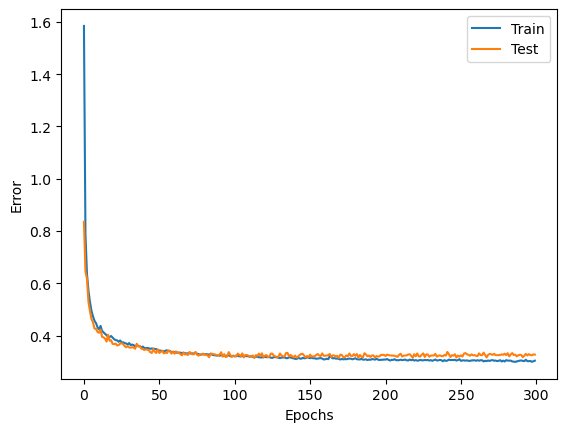

In [11]:
# 誤差の推移
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [12]:
MODEL_DIR = "F:/model/D4/nomal_model300"
torch.save(net.state_dict(), MODEL_DIR)

In [ ]:
print(record_loss_train.dtype)

In [13]:
LOSS_TRAIN_DIR = "F:/model/D4/nomal_model300_loss_train.npy"
LOSS_TEST_DIR = "F:/model/D4/nomal_model300_loss_test.npy"

loss_train = np.array(record_loss_train)
loss_test = np.array(record_loss_test)

np.save(LOSS_TRAIN_DIR, loss_train)
np.save(LOSS_TEST_DIR, loss_test)

# モデルの読み込み、推論

In [14]:
from Tacotron2 import Tacotron2

MODEL_DIR = "F:/model/D4/nomal_model100"
net2 = Tacotron2()
net2.load_state_dict(torch.load(MODEL_DIR))

<All keys matched successfully>

In [15]:
net2.cuda()

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(66, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [35]:
from torch.utils.data import DataLoader

data_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
text, text_len, mel, mel_len, stop_flags = next(iter(data_loader))

#plt.imshow(image[0].permute(1, 2, 0))
#print(image)

net2.eval()
text = text.cuda()

In [36]:
print(tuple(text.shape))
print(tuple(mel.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(text_len.dtype)
print(mel_len.dtype)

(2, 60)
(2, 561, 80)
tensor([60, 33])
tensor([561, 329])
torch.int32
torch.float64
torch.int64
torch.int64


In [37]:
text_len, indices = torch.sort(text_len, dim=0, descending=True)
text, mel, mel_len = text[indices], mel[indices], mel_len[indices]  
text, mel, stop_flags = text.cuda(), mel.float().cuda(), stop_flags.cuda()
        
# 順伝播
outs, outs_fine, logits, att_ws = net2(text, text_len, mel.transpose(1, 2))

In [38]:
outs, outs_fine, logits, att_ws = net2.inference(text, text_len)

In [39]:
import matplotlib.pyplot as plt

def plot_attention(alignment):
    """Plot attention.
    Args:
        alignment (np.ndarray): Attention.
    """
    fig, ax = plt.subplots()
    alignment = alignment.cpu().data.numpy().T
    im = ax.imshow(alignment, aspect="auto", origin="lower", interpolation="none")
    fig.colorbar(im, ax=ax)
    plt.xlabel("Decoder time step")
    plt.ylabel("Encoder time step")
    #return fig

torch.Size([539, 60])


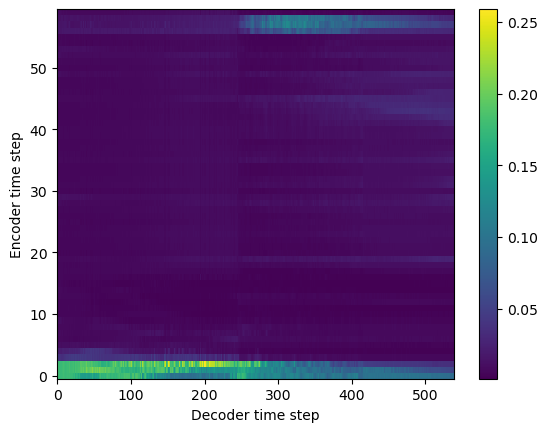

In [40]:
print(att_ws[0].shape)
plot_attention(att_ws[0])

In [ ]:
outs = outs.to('cpu').detach().numpy()
print(outs.shape)
outs_fine = outs_fine.to('cpu').detach().numpy()
print(outs_fine.shape)

In [ ]:
OUTPUT_PATH = "F:/ROHAN4600マルチモーダルデータベース/mel_outs/"
outsdir = OUTPUT_PATH + "outs_1.npy"
outsfinedir = OUTPUT_PATH + "outs_fine_1.npy"
np.save(outsdir, outs)
np.save(outsfinedir, outs_fine)